In [30]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ,BasicAer,execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')
manila = provider.get_backend('ibmq_manila')
qiskit.__qiskit_version__

ibmqfactory.load_account:WARNING:2022-05-01 20:40:44,636: Credentials are already in use. The existing account in the session will be replaced.


{'qiskit-terra': '0.20.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': None, 'qiskit': '0.36.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

# For Three Qubits
We create state that
$|\psi\rangle = \frac{1}{\sqrt{2}} (|000\rangle +i|111\rangle)
$


In [48]:

#create state 1/sqrt(2)*(|000>+i|111>)
q1 = QuantumRegister(3,'q')
c1 = ClassicalRegister(3,'c')
circuit = QuantumCircuit(q1, c1)
circuit.h(q1[0])
circuit.h(q1[1])
circuit.cx(q1[1],q1[2])
circuit.h(q1[1])
circuit.cx(q1[0],q1[2])
circuit.h(q1[0])
circuit.h(q1[2])
circuit.s(q1[2])
circuit.barrier()
circuit.draw(output='mpl')
states_three = ['000','001','010','011','100','101','110','111']

# For Four Qubits
We create state that
$|\psi\rangle = \frac{1}{\sqrt{2}} (|0000\rangle +i|1111\rangle)
$

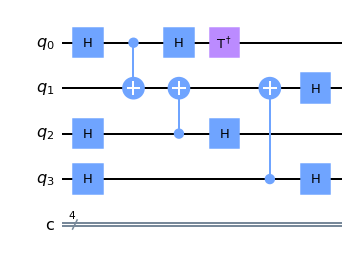

In [32]:
q2 = QuantumRegister(4, 'q')
c2 = ClassicalRegister(4, 'c')
circuit2 = QuantumCircuit(q2, c2)

circuit2.h(q2[0])
circuit2.h(q2[2])
circuit2.h(q2[3])
circuit2.cx(q2[0], q2[1])
circuit2.h(q2[0])
circuit2.cx(q2[2], q2[1])
circuit2.h(q2[2])
circuit2.cx(q2[3], q2[1])
circuit2.h(q2[1])
circuit2.h(q2[3])
circuit2.tdg(q2[0])
circuit2.draw(output='mpl')

In [33]:
def measure_state(name,q,c,circuit):
    measurename = QuantumCircuit(q,c)
    state = 0
    for i in name:
        if i == 'X':
            measurename.h(q[state])
        elif i == 'Y':
            measurename.sdg(q[state])
            measurename.h(q[state])
        state += 1
    for i in range(state):
        measurename.measure(q[i],c[i])

    circuitname = circuit+measurename
    return circuitname


In [34]:
circuitYXX= measure_state('YXX',q1,c1,circuit)
circuitXYX= measure_state('XYX',q1,c1,circuit)
circuitXXY= measure_state('XXY',q1,c1,circuit)
circuitYYY= measure_state('YYY',q1,c1,circuit)


/tmp/ipykernel_2820/3962558020.py:14: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuitname = circuit+measurename


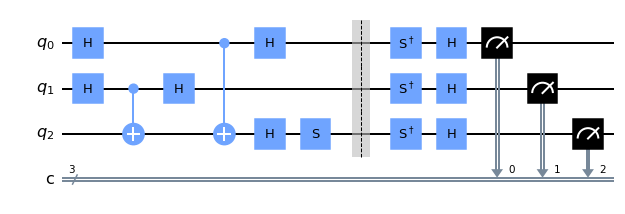

In [35]:
circuitYYY.draw(output='mpl')

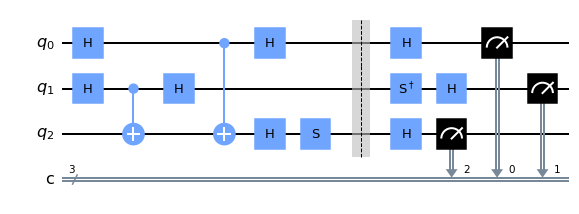

In [36]:
circuitXYX.draw(output='mpl')

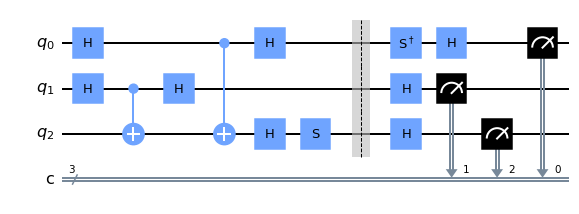

In [37]:
circuitYXX.draw(output='mpl')

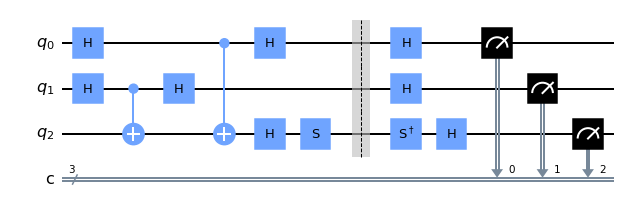

In [43]:
circuitXXY.draw(output='mpl')

In [39]:
def runcircuit(device,shots,circuits):
    transpiled_circuits = transpile(circuits, device)
    job_real = device.run(transpiled_circuits, shots=shots)
    job_monitor(job_real)
    result_real = job_real.result()

    counts = []
    for i in circuits:
        counts.append(result_real.get_counts(i))
    return counts


In [40]:
def ideal_run(shots,circuits):
    sim = Aer.get_backend('aer_simulator')
    result_ideal = sim.run(circuits,shots).result()
    ideal_counts=[]
    for i in circuits:
        ideal_counts.append(result_ideal.get_counts(i))
    return ideal_counts


In [72]:
def expectation(counts,shots,states):
    Exp=[]
    for i in range(len(counts)):
        probs = 0
        for output in states:
            num = sum(int(i) for i in output)
            if output in counts[i]:
                if(num % 2 == 0):
                    probs += counts[i][output]/shots
                else:
                    probs -= counts[i][output]/shots
            else:
                probs += 0
        Exp.append(probs)
    print(Exp)
    print(Exp[1]+Exp[2]+Exp[3]-Exp[0])


In [74]:
circuits=[circuitYYY,circuitYXX,circuitXYX,circuitXXY]
shots=1024
ideal = ideal_run(shots,circuits)
expectation(ideal,shots,states_three)

[-1.0, 1.0, 1.0, 1.0]
4.0
